<center> <h1> Practice Exam Solution</h1> </center> 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smfb
from scipy import sparse
from sklearn ibmport linear_model
from sklearn.linear_model import LassoCV

In [5]:
def plot_lassoCV(lasso,nfolds):
     #1se rule 
    mean = np.mean(lasso.mse_path_, axis=1)
    std_error = np.std(lasso.mse_path_, axis=1)/np.sqrt(nfolds)
    mean_min  = mean[lasso.alphas_==lasso.alpha_]
    std_min   = std_error[lasso.alphas_==lasso.alpha_]
    alpha_1se = np.max(lasso.alphas_[mean <= mean_min + std_min])

    # Plot    
    plt.semilogx(lasso.alphas_, np.mean(lasso.mse_path_, axis=1))

    plt.semilogx(lasso.alphas_, mean + std_error, "b--")
    plt.semilogx(lasso.alphas_, mean - std_error, "b--")
    plt.fill_between(lasso.alphas_, mean + std_error, mean - std_error, alpha=0.2)
    plt.axvline(lasso.alpha_, linestyle="--", color="black", label="$\lambda_{min}$")
    plt.axvline(alpha_1se, linestyle="--", color="red", label="$\lambda_{1se}$")
    plt.legend()
    plt.xlabel("$\log(\lambda)$")
    plt.ylabel("Mean Squared Error")
    plt.show() 
    
def get_coef(lasso,scale,coeffnames):
    # getting the coefficients and picking those that are not zero
    coefficients = np.append(lasso.intercept_, lasso.coef_/scale) 
    coeffnames = coeffnames[coefficients != 0]
    coeffvalues = coefficients[coefficients != 0]
    # return non-zero ones 
    return pd.DataFrame([coeffnames, coeffvalues]).T

## QUESTION 1: (4 sub-questions, 20 points)
The 4 sub-questions of this question are not related to each other.

### QUESTION 1.1 (5 points)
You want to study the effect of class sizes on student achievement.You have data from an experiment in which Tennessee schools created some smaller classes and randomly assigned each student to either a small class or to a regular-sized class. It was, however, left to each school to decide how many small classes they wanted to have. Thus, the randomization only assured that within schools students were randomly assigned to classes of different sizes.
Download and view Table 2 from the academic study that analyzes data from this experiment; the table is provided in the PDF file “star_table.pdf”. The columns labeled (1) and (2) present two regressions run by the study’s authors. The table reports standard errors in parentheses below the coefficient estimates.


Why did the authors run these regressions? What do we learn from these results? Be sure to explain why columns (1) and (2) differ and which one is the more appropriate one to use given the nature of the randomization.


**ANSWER:** The table shows regression output for two regressions of treatment on various demographics; thus, these regressions provide a randomization check.

Given that schools can choose their own proportion of small vs regular-sized classes, column (2) provides the more appropriate regression to use to assess the quality of the randomization. That is, because student assignment to small-vs-large classes is random within a school but not across schools, it is necessary to control for school fixed effects in the randomization check.

The coefficient estimates for the demographics differ between columns (1) and (2) because (2) includes school fixed effects. The change in coefficient estimates must result from the fact that demographics vary by school.

All coefficients for demographics in column (2) are within 2 standard errors of zero (i.e., no demographic is statistically significant), which is consistent with random assignment of treatment.


### QUESTION 1.2 (5 points)
You are tasked to implement a randomized experiment in order to test the effectiveness (measured in grade point averages, “GPA”) of new schooling material for high school students. At one high school, you are planning to randomly give the material to a subset of students, but not other students at that same school. From historic data (i.e. before the intervention) you know that the variance of the GPA score is equal to 1.3. The organization expects an increase in GPA scores of 0.1 due to the intervention. Assume that the treatment / control proportions are equal to 80% / 20%.
How large does the sample size have to be in order to be able to find a positive effect on GPA scores at the 97.5 percent level of confidence (i.e., $t_{critical}=1.96$)?



**ANSWER:** We want 

$$N=\frac{s^2}{Var(X)\cdot SE^2},$$

with $SE<0.1/1.96$. Using the historical variance of GPA as a proxy for $s^2$, we have

$$
N>\frac{1.3\cdot 1.96^2}{0.8\cdot0.2\cdot 0.1^2}= 3121.3.
$$

You can thus pick $N\ge 3122$.


### QUESTION 1.3 (5 points)
You are running an A/B test to assess whether a new online ad campaign will increase revenue relative to your current campaign. Suppose you find that your new campaign does not outperform the old one. You wonder if the new campaign might only appeal to certain demographic groups. You therefore split the sample into male/female and 10 age bins for each gender (i.e. 20 bins in total). Only for 1 of the 20 demographic groups (women between ages 20 and 25) are you able to reject the null hypothesis that the new campaign has the same effect as the old one.

Based on this result, would you advise your marketing manager to target the new campaign specifically to this demographic group (and show the old ad to everybody else)? Explain your reasoning.


**ANSWER:** Here we find 5% of our variables are statistically significant at a 95% confidence level, which is exactly the expected Type I error rate (i.e., the probability that we erroneously find a statistically significant result by chance when in fact there is no true effect is 5%).

You thus conclude that there is no statistically-detectable difference between the performance of the new and old ad campaigns.


### QUESTION 1.4 (5 points)
You are trying to optimize pricing for a product sold at a large number of stores. You implement an A/B test where you randomly vary price. However, you are only able to randomly vary prices for a given store relative to the historical price level at that store. Because prices differed across stores in the past, the A/B test only generates random variation in prices within stores, whereas price differences across stores are not random. Assume that the only variable that is correlated with price across stores is advertising and that stores with higher prices advertise more. Suppose you have panel data set on these randomized prices and on sales at the week/store level.

Explain why a regression of sales on price would give you a biased estimate of the price coefficient and explain which regression you would run instead to remove the bias. Then use the omitted variables bias formula to guess the sign of the bias in the first regression.


**ANSWER:** Price is not randomly assigned across stores and therefore some of the price variation used in this regression is non-random. A regression with store fixed effects will remove the bias. The price coefficient is likely overestimated when not including store fixed effects. Thinking of advertising as the omitted variable, we know that price and advertising are positively correlated, and we expect advertising to positively affect demand.


## QUESTION 2. Predicting credit default (4 sub-questions, 20 points)
You are working at a FinTech start-up which is trying to use demographic data to predict default risk for small loans. You have access to historic data on loans, including information on a set of demographics, whether the loan was repaid, and the interest rate (coded as a percentage, i.e. between 0 and 100) that was charged to the customer. Demographics are coded as 100 mutually exclusive groups (each constitutes a unique demographic characteristic).

The company used demographics to predict default risk in the past and charged different interest rates based on the default predictions. Your task is to update the targeting algorithm based on new data (the credit_default data-set).


In [2]:
credit_default   = pd.read_csv('credit_default.csv')
credit_default  .head()

,consumer_id,demo_group,default_dummy,interest_rate
0,1,79,0,6.0
1,2,53,0,6.0
2,3,70,0,6.0
3,4,9,0,6.0
4,5,38,0,6.0


### QUESTION 2.1 (5 points)
The following output is from a cross-validated Lasso where the candidate X-variables are the dummies for all 100 demographic groups. Interpret the results from this regression.

In [12]:
# make categorical variables into dummy columns, this is the dataframe we will use to generate X in lasso
df_demo = pd.get_dummies(credit_default["demo_group"], columns=['demo_group'],drop_first=True)
df_demo = df_demo.add_prefix('demo_group_')
#
df_demo.head()

,demo_group_2,demo_group_3,demo_group_4,demo_group_5,demo_group_6,demo_group_7,demo_group_8,demo_group_9,demo_group_10,demo_group_11,...,demo_group_91,demo_group_92,demo_group_93,demo_group_94,demo_group_95,demo_group_96,demo_group_97,demo_group_98,demo_group_99,demo_group_100
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# X variables to try for LASSO
X = sparse.csc_matrix(df_demo)
# Y variables to try for LASSO
Y = credit_default['default_dummy']
# We run CV Lasso
nfolds  = 10
lassocv = LassoCV(cv = nfolds, max_iter = 10000)
lassocv.fit(X,Y)

LassoCV(cv=10, max_iter=10000)

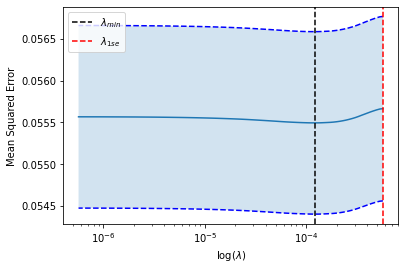

In [14]:
plot_lassoCV(lassocv,nfolds)

In [15]:
coeffnames = list(df_demo.columns)
coeffnames.insert(0,'(Intercept)')
coeffnames = np.array(coeffnames)
get_coef(lassocv,1,coeffnames)

,0,1
0,(Intercept),0.059131
1,demo_group_9,0.005629
2,demo_group_10,0.03566
3,demo_group_12,0.018453
4,demo_group_15,0.02749
5,demo_group_17,0.037516
6,demo_group_21,-0.025074
7,demo_group_23,0.007677
8,demo_group_25,-0.001674
9,demo_group_27,-0.046385


**ANSWER:** Only a limited number of demographics are retained in the regression, suggesting that including all demographic dummies would lead to overfitting. Demographics 27, 28 and 45 are the ones more strongly associated (in absolute value) with defaults.


### QUESTION 2.2 (5 points)
The following cross-validated Lasso regression includes the interest rate as well as the demographics in the set of X-variables to select from. How do the results differ from the ones in 1.1? Why are fewer demographics retained when also including the interest rate among the candidate X variables?

In [16]:
# X variables to try for LASSO
X_interest = sparse.csc_matrix(pd.concat([df_demo, credit_default["interest_rate"]], axis=1))

# We run CV Lasso
nfolds  = 10
lassocv_interest = LassoCV(cv = nfolds, max_iter = 1000)
lassocv_interest.fit(X_interest,Y)

LassoCV(cv=10)

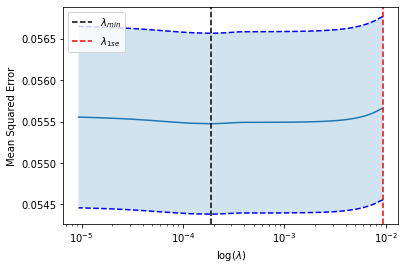

In [17]:
plot_lassoCV(lassocv_interest,nfolds)

In [19]:
coeffnames = list(pd.concat([df_demo, credit_default["interest_rate"]], axis=1).columns)
coeffnames.insert(0,'(Intercept)')
coeffnames = np.array(coeffnames)
get_coef(lassocv_interest,1,coeffnames)

,0,1
0,(Intercept),-0.058912
1,demo_group_15,0.021755
2,demo_group_21,-0.018037
3,demo_group_23,0.00161
4,demo_group_40,-0.000827
5,demo_group_41,-0.017965
6,demo_group_46,-0.000688
7,demo_group_53,0.006602
8,demo_group_54,0.001979
9,demo_group_79,0.00854


**ANSWER:** The interest rate was set based on demographics (and how they predict default) in the past. Hence we would expect the interest rate to be highly correlated with the set of demographics that predict default in the current data. After controlling for past interest rates, some demographics might not provide additional explanatory power and hence Lasso does not retain them.


### QUESTION 2.3 (5 points)
The following code runs a regression of the default dummy on the interest rate and computes the a R-squared for the Lasso regression in question 2.2. Based on the comparison of the R-squared from the first regression and the Lasso R-squared, do you think that interest rates were well targeted in your data (i.e., past interest rates are a good predictor of default)?


In [22]:
interest_reg   = smf.ols(formula = 'default_dummy ~ interest_rate', data = credit_default).fit()
print(interest_reg.summary())
print(interest_reg.rsquared)

                            OLS Regression Results                            
Dep. Variable:          default_dummy   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     159.4
Date:                Tue, 08 Mar 2022   Prob (F-statistic):           1.75e-36
Time:                        13:13:38   Log-Likelihood:                 1344.9
No. Observations:               50000   AIC:                            -2686.
Df Residuals:                   49998   BIC:                            -2668.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.0550      0.009     -6.041

In [21]:
credit_default["prediction"] = lassocv_interest.predict(X_interest)
credit_default["residual"] = credit_default["default_dummy"] - credit_default["prediction"]
1 - np.var(credit_default["residual"])/np.var(credit_default["default_dummy"])

0.003994606371087617

**ANSWER:** The R-squared from the simple regression (0.0031776768727018734) is only slightly lower than the R-squared from the Lasso regression (0.003994606371087617). This suggests that the past interest rate alone is a strong predictor of default, so it is well targeted, in the sense that higher-risk customers receive higher interest rates. However, the interest rate alone does not perfectly capture the relevant demographics (if it did, only the interest rate would have been retained in the Lasso regression).


### QUESTION 2.4 (5 points)
Which Lasso regression (with or without the interest rate) would you use to decide how to set interest rates in the future for **NEW** customers?

**ANSWER:** Interest rates for new customers have to be set based on the Lasso regression that does not include the interest rate. By construction, a new customer will not have been charged an interest rate yet and hence this variable cannot be used for prediction.


## QUESTION 2. Yelp Star Ratings (5 sub-questions, 25 points)
You want to study the impact of star ratings (yelp_star) on clicks to restaurant websites in the Yelp platform. You have data on average daily clicks across a range of restaurants and the star ratings for those restaurants (which vary in half-star increments and take on values in the range 5, 4.5, …, 2.5). The data also contain the actual average Yelp score underlying the star rating (yelp_score). The star rating is equal to the actual average Yelp score (e.g., 4.1374) rounded to the nearest half-star value (e.g., 4.0).


### QUESTION 2.1 (5 points)
You regress clicks on yelp_star and yelp_score and obtain the following estimated relationship (two stars next to a coefficient indicate significance at the 5% level; no stars indicate no significance at the 5% level):

$$
clicks = -41.4^{**} +2.9^{**}yelp\_star +23.6^{**}yelp\_score+error
$$


Interpret the coefficients.

**ANSWER:** Holding the yelp_score constant, a half star increase in the yelp_star ratings is associated with a 2.9 increase in average daily clicks. The intercept is not meaningful here as there are no restaurants with zero stars in the dataset. The yelp_score is positively correlated with clicks.

### QUESTION 2.2 (5 points)
A regression of clicks on yelp_star only gives the following estimates (two stars next to a coefficient indicate significance at the 5% level; no stars indicate no significance at the 5% level):

$$
clicks = -36.4^{**} +25.2^{**}yelp\_star+error
$$

Use the omitted variables bias formula to explain the change in the coefficient on the yelp_star variable between the two regressions in questions 2.1 and 2.2.


**ANSWER:** The coefficient decreases when controlling for yelp_score. This is because the score is positively correlated with clicks (as we see from the 2.1 regression) and is also positively correlated with yelp_star by definition (the higher the score, the higher the rounded number, i.e., the higher the star rating). The univariate regression thus suffers from positive omitted variable bias so the coefficient on yelp_star goes down once controlling for yelp_score.


### QUESTION 2.3 (5 points)
Under which assumption does the yelp_star variable have a causal interpretation?

**ANSWER:** We would like to know if star ratings cause more clicks. Under the assumption that, after controlling for yelp_score, yelp_star ratings only affect clicks directly (not indirectly via correlation with any other variable), then the yelp_star ratings variable has a causal interpretation. Here, this assumption probably holds because star ratings is a function of score (and nothing else).
You can also think of this as a regression of clicks on yelp_star, where yelp_score is the only omitted variable impacting the yelp_star rating coefficient. Once we control for yelp_score, the coefficient on yelp_star has a causal interpretation.


### QUESTION 2.4 (5 points)
Suppose you have data for all the stores in the Yelp dataset at two different months in a given year, and suppose that for each store you can measure clicks and yelp_star ratings at each month, but cannot measure yelp_score. Explain how you would use these data to estimate the causal effect of yelp_star on clicks. Which condition on the time variation in yelp_star ratings must be satisfied for you to be able to estimate this causal effect?

**ANSWER:** You can use a panel data regression with store fixed effects to control for the unobservable omitted variable “store quality” (since this is plausibly constant within a year). You need at least some stores to change their ratings between the two months, otherwise you cannot pin down the causal effect of ratings if all of them stay constant (the variable would be explained by the store fixed effects and dropped from the regression or you would have a multicollinearity problem).
